<a href="https://colab.research.google.com/github/Ira00/nn2022/blob/main/LR_6/LR_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Лабораторна робота №6
студентки 3 курсу групи КН-31
Івахненко Ірини

## Імпорт zip файла

In [ ]:
import zipfile

# Download zip file of pizza_steak images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip 

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("101_food_classes_10_percent.zip", "r")
zip_ref.extractall()
zip_ref.close()

--2022-05-01 17:09:19--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.219.128, 209.85.146.128, 209.85.147.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.219.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G   217MB/s    in 9.1s    

2022-05-01 17:09:29 (170 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



## Вибір класів відповідно до варіанту 6, 36, 66

In [ ]:
import pathlib
import numpy as np
data_dir = pathlib.Path("101_food_classes_10_percent/train/") # turn our training path into a Python path
class_names = np.array(sorted([item.name for item in data_dir.glob('*')])) # created a list of class_names from the subdirectories
my_class_names = [class_names[6], class_names[36], class_names[66]]
print(my_class_names)

['beignets', 'falafel', 'nachos']


## Фільтрування даних, залишення лише відповідно варіанту

In [ ]:
train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

from pathlib import Path
import shutil

for i in class_names:
  if i not in my_class_names:
    dirpath = Path(train_dir) / i
    if dirpath.exists() and dirpath.is_dir():
        shutil.rmtree(dirpath)
    dirpath = Path(test_dir) / i
    if dirpath.exists() and dirpath.is_dir():
        shutil.rmtree(dirpath) 
!ls 101_food_classes_10_percent/train/
!ls 101_food_classes_10_percent/test/

beignets  falafel  nachos
beignets  falafel  nachos


## Імпортування даних з каталогів і перетворення їх на пакети

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

tf.random.set_seed(42)

train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(test_dir,
                                               target_size=(224, 224),
                                               batch_size=32,
                                               class_mode='categorical')

test_data = train_datagen.flow_from_directory(train_dir,
                                              target_size=(224, 224),
                                              batch_size=32,
                                              class_mode='categorical')

train_datagen_augmented = ImageDataGenerator(rescale=1/255.,
                                             rotation_range=20, 
                                             width_shift_range=0.2,
                                             height_shift_range=0.2,
                                             zoom_range=0.2,
                                             horizontal_flip=True)

train_data_augmented = train_datagen_augmented.flow_from_directory(test_dir,
                                                                  target_size=(224, 224),
                                                                  batch_size=32,
                                                                  class_mode='categorical')

Found 750 images belonging to 3 classes.
Found 225 images belonging to 3 classes.
Found 750 images belonging to 3 classes.


## Навчання мережі CNN

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense
from keras.callbacks import TensorBoard

tensorboard = TensorBoard(log_dir='logs/cnn', histogram_freq=1)

model = Sequential([
  Conv2D(32, 3, activation='relu', input_shape=(224, 224, 3)),
  MaxPool2D(),
  Conv2D(32, 3, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(3, activation='softmax')
])

model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

history_model = model.fit(train_data_augmented,
                          epochs=40,
                          steps_per_epoch=len(train_data_augmented),
                          validation_data=test_data,
                          validation_steps=len(test_data),
                          callbacks=[tensorboard])

Epoch 1/40
24/24 [==============================] - 23s 554ms/step - loss: 1.1494 - accuracy: 0.4480 - val_loss: 0.9757 - val_accuracy: 0.4933
Epoch 2/40
24/24 [==============================] - 13s 535ms/step - loss: 0.9248 - accuracy: 0.5600 - val_loss: 0.9186 - val_accuracy: 0.5378
Epoch 3/40
24/24 [==============================] - 13s 532ms/step - loss: 0.8660 - accuracy: 0.6013 - val_loss: 0.8999 - val_accuracy: 0.5911
Epoch 4/40
24/24 [==============================] - 13s 536ms/step - loss: 0.8495 - accuracy: 0.6107 - val_loss: 0.8930 - val_accuracy: 0.5911
Epoch 5/40
24/24 [==============================] - 13s 542ms/step - loss: 0.7381 - accuracy: 0.6667 - val_loss: 0.9153 - val_accuracy: 0.6000
Epoch 6/40
24/24 [==============================] - 13s 535ms/step - loss: 0.7142 - accuracy: 0.6853 - val_loss: 0.7887 - val_accuracy: 0.6267
Epoch 7/40
24/24 [==============================] - 13s 536ms/step - loss: 0.7169 - accuracy: 0.6747 - val_loss: 0.8276 - val_accuracy: 0.5956

In [8]:
# %load_ext tensorboard
# %tensorboard --logdir logs/cnn

Loss
epoch_loss.svg

Accuracy
epoch_accuracy.svg

## Навчання мережі Resnet

In [17]:
import tensorflow_hub as hub

tensorboard_2 = TensorBoard(log_dir='logs/resnet', histogram_freq=1)

model_2 = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/imagenet/resnet_v1_101/feature_vector/5",
                   trainable=False),  # Can be True, see below.
    tf.keras.layers.Dense(3, activation='softmax')
])
model_2.build([None, 224, 224, 3])  # Batch input shape.

model_2.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

history_model_2 = model_2.fit(train_data_augmented,
                          epochs=40,
                          steps_per_epoch=len(train_data_augmented),
                          validation_data=test_data,
                          validation_steps=len(test_data),
                          callbacks=[tensorboard_2])

Epoch 1/40
24/24 [==============================] - 38s 1s/step - loss: 0.8599 - accuracy: 0.6227 - val_loss: 0.5462 - val_accuracy: 0.7778
Epoch 2/40
24/24 [==============================] - 28s 1s/step - loss: 0.3485 - accuracy: 0.8707 - val_loss: 0.3945 - val_accuracy: 0.8622
Epoch 3/40
24/24 [==============================] - 28s 1s/step - loss: 0.2557 - accuracy: 0.9040 - val_loss: 0.3643 - val_accuracy: 0.8578
Epoch 4/40
24/24 [==============================] - 27s 1s/step - loss: 0.2394 - accuracy: 0.9173 - val_loss: 0.3307 - val_accuracy: 0.8711
Epoch 5/40
24/24 [==============================] - 27s 1s/step - loss: 0.2142 - accuracy: 0.9173 - val_loss: 0.3738 - val_accuracy: 0.8578
Epoch 6/40
24/24 [==============================] - 27s 1s/step - loss: 0.1799 - accuracy: 0.9267 - val_loss: 0.3152 - val_accuracy: 0.8800
Epoch 7/40
24/24 [==============================] - 28s 1s/step - loss: 0.1859 - accuracy: 0.9267 - val_loss: 0.3854 - val_accuracy: 0.8533
Epoch 8/40
24/24 [==

In [19]:
# %tensorboard --logdir logs/resnet

Loss
epoch_loss-2.svg

Accurancy
epoch_accuracy-2.svg

## Навчання мережі Efficientnet

In [26]:
tensorboard_3 = TensorBoard(log_dir='logs/efficientnet', histogram_freq=1)

model_3 = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1",
                   trainable=False),  # Can be True, see below.
    tf.keras.layers.Dense(3, activation='softmax')
])

model_3.build([None, 224, 224, 3])


model_3.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

history_3 = model_3.fit(train_data_augmented,
                          epochs=25,
                          steps_per_epoch=len(train_data_augmented),
                          validation_data=test_data,
                          validation_steps=len(test_data),
                          callbacks=[tensorboard_3])

Epoch 1/25
24/24 [==============================] - 33s 779ms/step - loss: 0.7501 - accuracy: 0.7093 - val_loss: 0.5564 - val_accuracy: 0.8000
Epoch 2/25
24/24 [==============================] - 17s 719ms/step - loss: 0.3662 - accuracy: 0.8947 - val_loss: 0.4421 - val_accuracy: 0.8267
Epoch 3/25
24/24 [==============================] - 17s 702ms/step - loss: 0.2684 - accuracy: 0.9227 - val_loss: 0.3815 - val_accuracy: 0.8533
Epoch 4/25
24/24 [==============================] - 17s 710ms/step - loss: 0.2303 - accuracy: 0.9213 - val_loss: 0.3516 - val_accuracy: 0.8622
Epoch 5/25
24/24 [==============================] - 17s 732ms/step - loss: 0.1986 - accuracy: 0.9453 - val_loss: 0.3316 - val_accuracy: 0.8756
Epoch 6/25
24/24 [==============================] - 17s 718ms/step - loss: 0.1846 - accuracy: 0.9520 - val_loss: 0.3121 - val_accuracy: 0.8844
Epoch 7/25
24/24 [==============================] - 17s 714ms/step - loss: 0.1653 - accuracy: 0.9520 - val_loss: 0.3089 - val_accuracy: 0.8844

In [35]:
# %tensorboard --logdir logs/efficientnet

Loss
epoch_loss-3.svg

Accuracy
epoch_accuracy-3.svg

## Навчання мережі Resnet SGD

In [29]:
import tensorflow_hub as hub

tensorboard_4 = TensorBoard(log_dir='logs/resnet(sgd)', histogram_freq=1)

model_4 = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/imagenet/resnet_v1_101/feature_vector/5",
                   trainable=False),  # Can be True, see below.
    tf.keras.layers.Dense(3, activation='softmax')
])
model_4.build([None, 224, 224, 3])  # Batch input shape.

model_4.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.SGD(),
              metrics=["accuracy"])

history_4 = model_4.fit(train_data_augmented,
                          epochs=25,
                          steps_per_epoch=len(train_data_augmented),
                          validation_data=test_data,
                          validation_steps=len(test_data),
                          callbacks=[tensorboard_4])

Epoch 1/25
24/24 [==============================] - 37s 1s/step - loss: 0.6579 - accuracy: 0.7333 - val_loss: 0.4647 - val_accuracy: 0.8133
Epoch 2/25
24/24 [==============================] - 27s 1s/step - loss: 0.3255 - accuracy: 0.8653 - val_loss: 0.3737 - val_accuracy: 0.8622
Epoch 3/25
24/24 [==============================] - 27s 1s/step - loss: 0.2479 - accuracy: 0.9000 - val_loss: 0.3352 - val_accuracy: 0.8889
Epoch 4/25
24/24 [==============================] - 26s 1s/step - loss: 0.2223 - accuracy: 0.9120 - val_loss: 0.2876 - val_accuracy: 0.8933
Epoch 5/25
24/24 [==============================] - 27s 1s/step - loss: 0.2187 - accuracy: 0.9160 - val_loss: 0.2753 - val_accuracy: 0.9067
Epoch 6/25
24/24 [==============================] - 28s 1s/step - loss: 0.2030 - accuracy: 0.9280 - val_loss: 0.3307 - val_accuracy: 0.8844
Epoch 7/25
24/24 [==============================] - 28s 1s/step - loss: 0.1660 - accuracy: 0.9360 - val_loss: 0.2949 - val_accuracy: 0.8844
Epoch 8/25
24/24 [==

In [33]:
# %tensorboard --logdir logs/resnet(sgd)

Loss
epoch_loss-4.svg

Accuracy
epoch_accuracy-4.svg

## Навчання мережі Efficientnet SGD

In [36]:
tensorboard_5 = TensorBoard(log_dir='logs/efficientnet(sgd)', histogram_freq=1)

model_5 = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1",
                   trainable=False),  # Can be True, see below.
    tf.keras.layers.Dense(3, activation='softmax')
])

model_5.build([None, 224, 224, 3])


model_5.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.SGD(),
              metrics=["accuracy"])

history_5 = model_5.fit(train_data_augmented,
                          epochs=25,
                          steps_per_epoch=len(train_data_augmented),
                          validation_data=test_data,
                          validation_steps=len(test_data),
                          callbacks=[tensorboard_5])

Epoch 1/25
24/24 [==============================] - 30s 750ms/step - loss: 0.8618 - accuracy: 0.6320 - val_loss: 0.7071 - val_accuracy: 0.7289
Epoch 2/25
24/24 [==============================] - 17s 700ms/step - loss: 0.5836 - accuracy: 0.8227 - val_loss: 0.5580 - val_accuracy: 0.7822
Epoch 3/25
24/24 [==============================] - 17s 698ms/step - loss: 0.4487 - accuracy: 0.8973 - val_loss: 0.4924 - val_accuracy: 0.8133
Epoch 4/25
24/24 [==============================] - 17s 705ms/step - loss: 0.3950 - accuracy: 0.8800 - val_loss: 0.4453 - val_accuracy: 0.8444
Epoch 5/25
24/24 [==============================] - 17s 699ms/step - loss: 0.3506 - accuracy: 0.8960 - val_loss: 0.4160 - val_accuracy: 0.8533
Epoch 6/25
24/24 [==============================] - 17s 705ms/step - loss: 0.3203 - accuracy: 0.9067 - val_loss: 0.3985 - val_accuracy: 0.8578
Epoch 7/25
24/24 [==============================] - 17s 703ms/step - loss: 0.3019 - accuracy: 0.9080 - val_loss: 0.3837 - val_accuracy: 0.8622

In [38]:
# %tensorboard --logdir logs/efficientnet(sgd)

Loss
epoch_loss-5.svg

Accuracy
epoch_accuracy-5.svg

## Навчання мережі Resnet SGD fine-tuning

In [40]:
import tensorflow_hub as hub

tensorboard_6 = TensorBoard(log_dir='logs/resnet(sgd)_fine-tunning', histogram_freq=1)

model_6 = tf.keras.applications.resnet50.ResNet50(classes=3, weights=None)

for layer in model_6.layers:
  layer.trainable = False;

for layer in model_6.layers[-10:]:
  layer.trainable = True;

model_6.build([None, 224, 224, 3])  # Batch input shape.

model_6.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.SGD(),
              metrics=["accuracy"])

history_6 = model_6.fit(train_data_augmented,
                          epochs=25,
                          steps_per_epoch=len(train_data_augmented),
                          validation_data=test_data,
                          validation_steps=len(test_data),
                          callbacks=[tensorboard_6])

Epoch 1/25
24/24 [==============================] - 25s 879ms/step - loss: 0.9763 - accuracy: 0.5360 - val_loss: 1.0969 - val_accuracy: 0.3333
Epoch 2/25
24/24 [==============================] - 20s 832ms/step - loss: 0.8551 - accuracy: 0.6160 - val_loss: 1.1001 - val_accuracy: 0.3333
Epoch 3/25
24/24 [==============================] - 20s 833ms/step - loss: 0.8004 - accuracy: 0.6693 - val_loss: 1.1061 - val_accuracy: 0.3333
Epoch 4/25
24/24 [==============================] - 20s 856ms/step - loss: 0.8074 - accuracy: 0.6360 - val_loss: 1.0976 - val_accuracy: 0.3689
Epoch 5/25
24/24 [==============================] - 20s 828ms/step - loss: 0.7976 - accuracy: 0.6520 - val_loss: 1.1003 - val_accuracy: 0.3333
Epoch 6/25
24/24 [==============================] - 20s 837ms/step - loss: 0.8102 - accuracy: 0.6480 - val_loss: 1.1013 - val_accuracy: 0.3556
Epoch 7/25
24/24 [==============================] - 20s 830ms/step - loss: 0.7900 - accuracy: 0.6453 - val_loss: 1.1228 - val_accuracy: 0.3333

In [42]:
# %tensorboard --logdir logs/resnet(sgd)_fine-tunning

Loss
epoch_loss-6.svg

Accuracy
epoch_accuracy-6.svg

## Навчання мережі Efficientnet SGD fine-tuning

In [44]:
tensorboard_7 = TensorBoard(log_dir='logs/efficientnet(sgd)_fine-tunning', histogram_freq=1)

model_7 = tf.keras.applications.efficientnet.EfficientNetB5(classes=3, weights=None)

for layer in model_7.layers:
  layer.trainable = False;

for layer in model_7.layers[-10:]:
  layer.trainable = True;

model_7.build([None, 224, 224, 3])


model_7.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.SGD(),
              metrics=["accuracy"])

history_7 = model_7.fit(train_data_augmented,
                          epochs=25,
                          steps_per_epoch=len(train_data_augmented),
                          validation_data=test_data,
                          validation_steps=len(test_data),
                          callbacks=[tensorboard_7])

Epoch 1/25
24/24 [==============================] - 52s 1s/step - loss: 4.3319 - accuracy: 0.3267 - val_loss: 1.1001 - val_accuracy: 0.3333
Epoch 2/25
24/24 [==============================] - 27s 1s/step - loss: 1.8588 - accuracy: 0.3320 - val_loss: 1.1637 - val_accuracy: 0.3333
Epoch 3/25
24/24 [==============================] - 26s 1s/step - loss: 1.8233 - accuracy: 0.3600 - val_loss: 1.1102 - val_accuracy: 0.3333
Epoch 4/25
24/24 [==============================] - 26s 1s/step - loss: 2.1649 - accuracy: 0.3093 - val_loss: 1.1315 - val_accuracy: 0.3333
Epoch 5/25
24/24 [==============================] - 26s 1s/step - loss: 1.7537 - accuracy: 0.3573 - val_loss: 1.1239 - val_accuracy: 0.3333
Epoch 6/25
24/24 [==============================] - 27s 1s/step - loss: 1.7628 - accuracy: 0.3800 - val_loss: 1.1140 - val_accuracy: 0.3333
Epoch 7/25
24/24 [==============================] - 27s 1s/step - loss: 1.8056 - accuracy: 0.3347 - val_loss: 1.0987 - val_accuracy: 0.3333
Epoch 8/25
24/24 [==

In [46]:
# %tensorboard --logdir logs/efficientnet(sgd)_fine-tunning

Loss
epoch_loss-7.svg

Accuracy
epoch_accuracy-7.svg

In [50]:
# %tensorboard --logdir logs

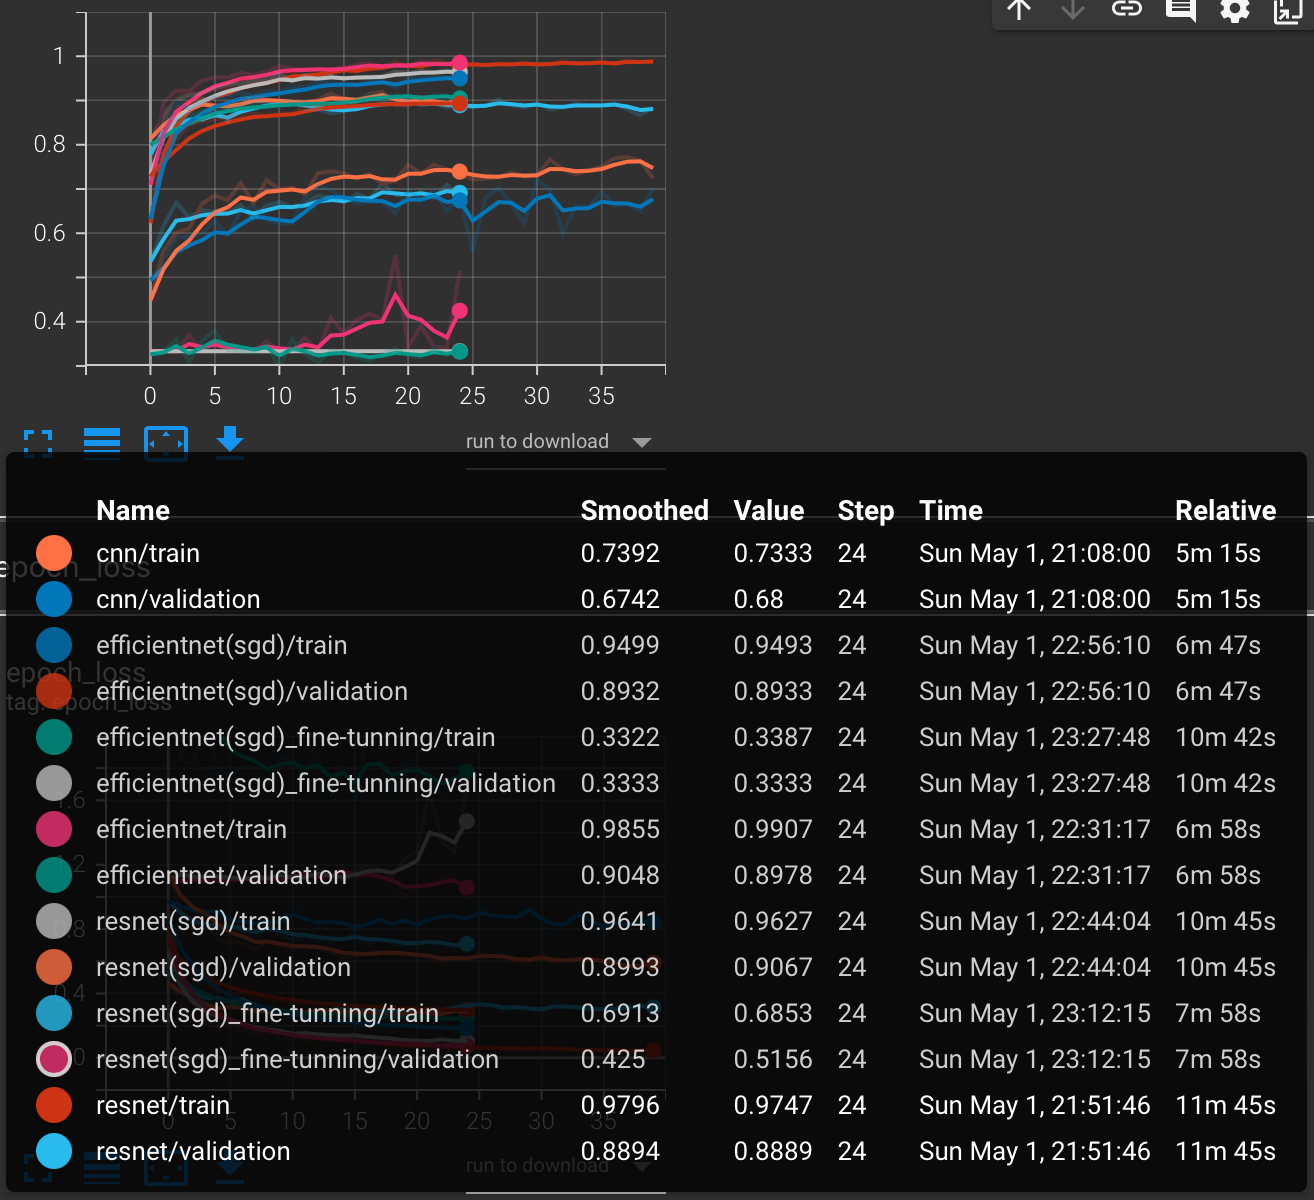

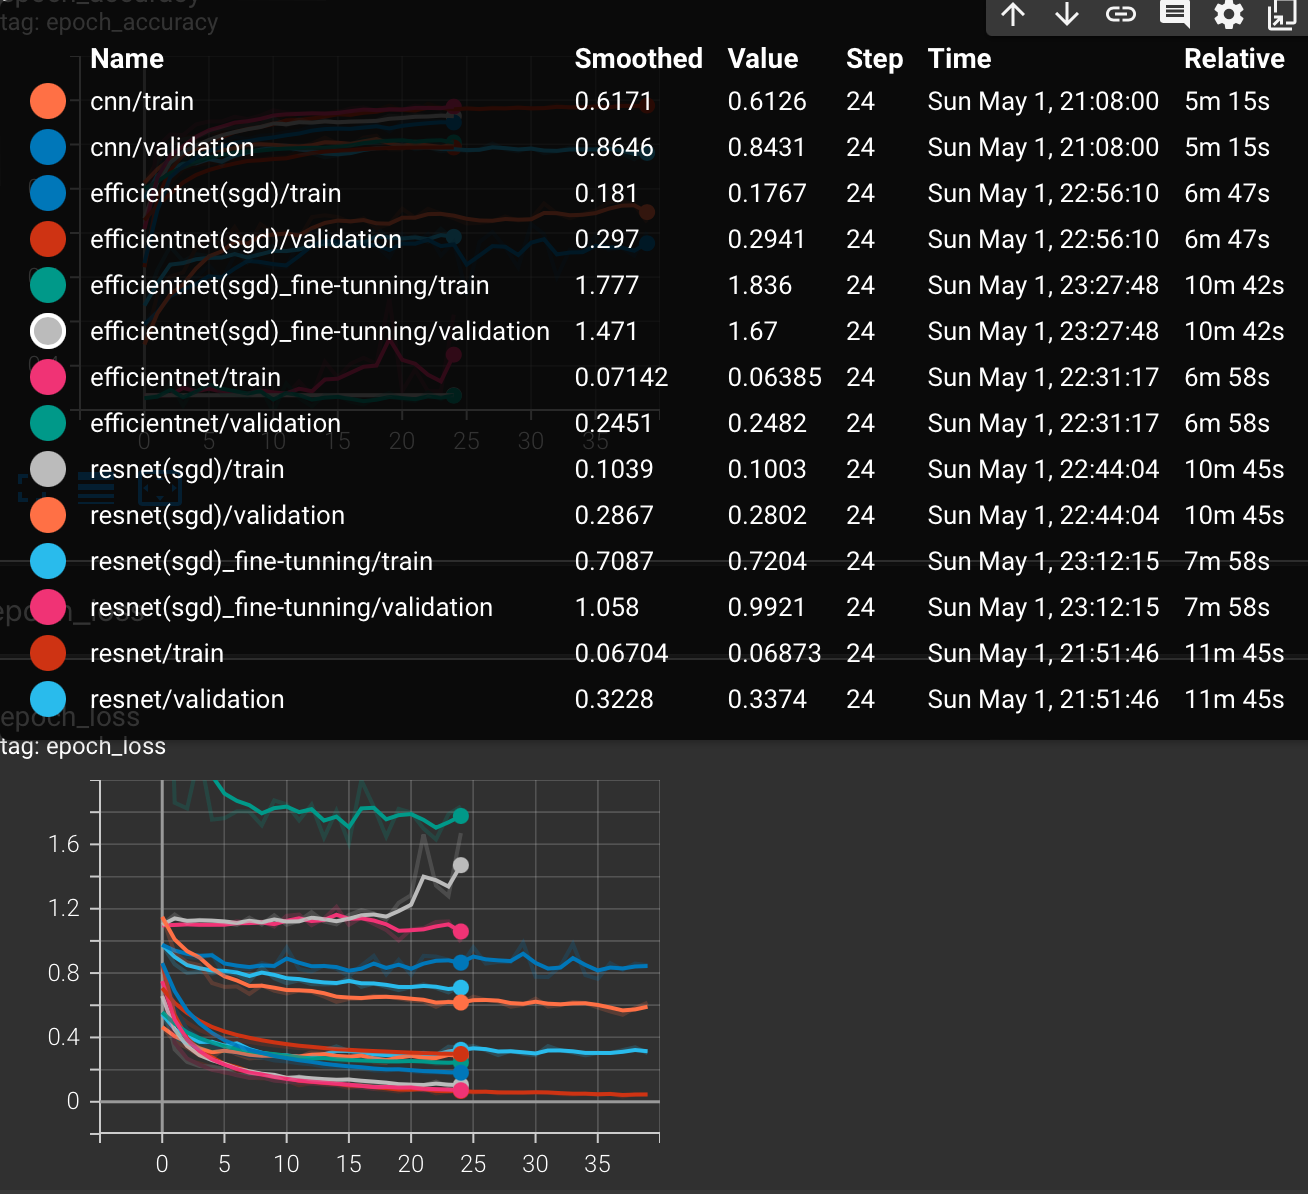

## Висновок:
в ході лабораторної роботи вирішили задачі класифікації для 3 класів з набору даних food101 з використанням різних моделей нейронних мереж. Найкраще відпрацювала модель Efficient з оптимізаторам Adam. Точність даної моделі - 0.9907, втрати 0.06385. Але на моменті валідації найкращі результати були у моделі Resnet з оптимізатором SGD. Точність - 0.9067, втрати 0.2802.